In [1]:
# -*- coding: utf-8 -*-
"""
02_text_recognition_training.ipynb

Text Recognition Training using CRNN + CTC
"""

USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_ROOT = "/content/drive/MyDrive/Information-Extraction-from-Image"
else:
    PROJECT_ROOT = os.path.abspath(".")

print("PROJECT_ROOT:", PROJECT_ROOT)


Mounted at /content/drive
PROJECT_ROOT: /content/drive/MyDrive/Information-Extraction-from-Image


In [2]:
# ===============================
# Standard Library
# ===============================
import os
import sys
import time
import random

# ===============================
# Third-party Libraries
# ===============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

# ===============================
# Project Configuration
# ===============================
DATASET_DIR = f"{PROJECT_ROOT}/datasets/SceneTrialTrain"
CROP_TEXT_DIR = f"{PROJECT_ROOT}/cropped_text"

os.makedirs(CROP_TEXT_DIR, exist_ok=True)
print("Created:", CROP_TEXT_DIR)
# Add project root to PYTHONPATH
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# ===============================
# Project Modules
# ===============================
from src.recognition import (
    extract_data_from_xml_for_recognition,
    crop_text,
    encode,
    decode,
    decode_label,
    STRDataset,
    CRNN,
)

# ===============================
# Device
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


Created: /content/drive/MyDrive/Information-Extraction-from-Image/cropped_text
Using device: cuda


# 1. Extract and Crop Text Regions for Recognition

In [3]:
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml_for_recognition(
    DATASET_DIR
)

print(f"Total images        : {len(img_paths)}")
print(f"Total text regions  : {sum(len(b) for b in bboxes)}")


Total images        : 250
Total text regions  : 1097


#2. Crop and Save Text Regions

In [4]:
cropped_img_paths, labels = crop_text(
    img_paths, img_labels, bboxes, save_dir = CROP_TEXT_DIR
)

print(f"Cropped images: {len(cropped_img_paths)}")
print(f"Example labels: {labels[:5]}")


Cropped images: 1097
Example labels: ['self', 'adhesive', 'address', 'labels', '36']


## Visualize samples

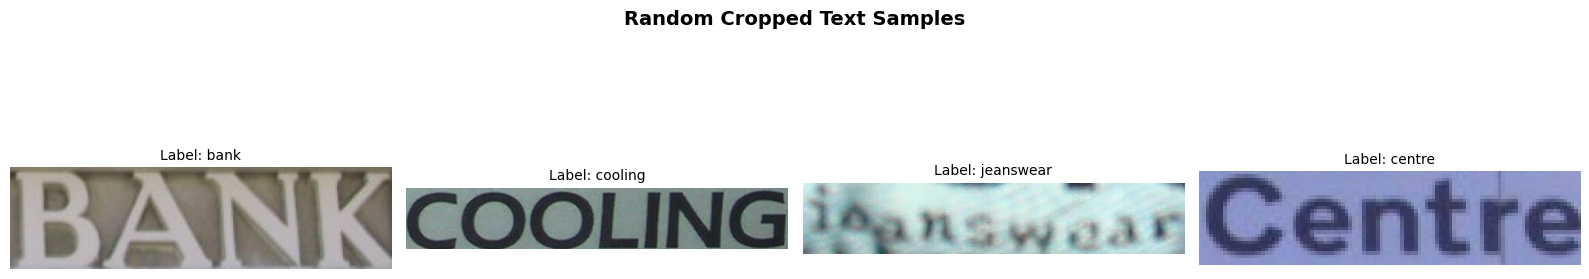

In [5]:
indices = random.sample(range(len(cropped_img_paths)), 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, idx in zip(axes, indices):
    img_path = cropped_img_paths[idx]
    label = labels[idx]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)
    ax.set_title(f"Label: {label}", fontsize=10)
    ax.axis("off")

plt.suptitle("Random Cropped Text Samples", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

#3. Prepare Characters and Encoding

In [6]:
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz-"
BLANK_CHAR = "-"

char_to_idx = {c: i + 1 for i, c in enumerate(sorted(CHARS))}
idx_to_char = {i: c for c, i in char_to_idx.items()}

vocab_size = len(CHARS)
max_label_len = max(len(l) for l in labels)

print(f"Vocabulary size : {vocab_size}")
print(f"Max label length: {max_label_len}")

Vocabulary size : 37
Max label length: 14


#4. Train/Val/Test Split for Recognition

In [7]:
SEED = 0
VAL_SIZE = 0.1
TEST_SIZE = 0.1

X_train, X_val, y_train, y_val = train_test_split(
    cropped_img_paths,
    labels,
    test_size=VAL_SIZE,
    random_state=SEED,
    shuffle=True,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=TEST_SIZE,
    random_state=SEED,
    shuffle=True,
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 888 | Val: 110 | Test: 99


#5. Enhanced Data Transforms and DataLoaders

In [8]:
## Data Transforms
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420), interpolation=2),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420), interpolation=2),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)

val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

train_batch_size = 256
test_batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#6. Define CRNN Model

In [9]:
crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=256,
    n_layers=3,
    dropout=0.2,
    unfreeze_layers=3,
).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

#7. Training Functions

In [10]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [11]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

#8. Train CRNN Model

In [12]:
epochs = 80
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[BLANK_CHAR],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    crnn_model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

train_losses, val_losses = fit(
    crnn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    DEVICE,
    epochs,
)

EPOCH 1:	Train loss: 7.5376	Val loss: 3.8310		 Time: 14.74 seconds
EPOCH 2:	Train loss: 4.2988	Val loss: 4.0021		 Time: 11.55 seconds
EPOCH 3:	Train loss: 3.8379	Val loss: 3.6382		 Time: 11.75 seconds
EPOCH 4:	Train loss: 3.6363	Val loss: 3.5054		 Time: 11.98 seconds
EPOCH 5:	Train loss: 3.4841	Val loss: 3.3622		 Time: 12.00 seconds
EPOCH 6:	Train loss: 3.4271	Val loss: 3.3652		 Time: 12.01 seconds
EPOCH 7:	Train loss: 3.4394	Val loss: 3.4304		 Time: 12.03 seconds
EPOCH 8:	Train loss: 3.3914	Val loss: 3.2743		 Time: 12.11 seconds
EPOCH 9:	Train loss: 3.3306	Val loss: 3.2412		 Time: 11.99 seconds
EPOCH 10:	Train loss: 3.2574	Val loss: 3.1523		 Time: 11.75 seconds
EPOCH 11:	Train loss: 3.2133	Val loss: 3.0816		 Time: 11.69 seconds
EPOCH 12:	Train loss: 3.1175	Val loss: 2.9676		 Time: 12.01 seconds
EPOCH 13:	Train loss: 3.0614	Val loss: 2.9065		 Time: 12.31 seconds
EPOCH 14:	Train loss: 2.9708	Val loss: 2.7936		 Time: 12.35 seconds
EPOCH 15:	Train loss: 2.7764	Val loss: 2.6507		 Time: 12.

#9. Plot Training History

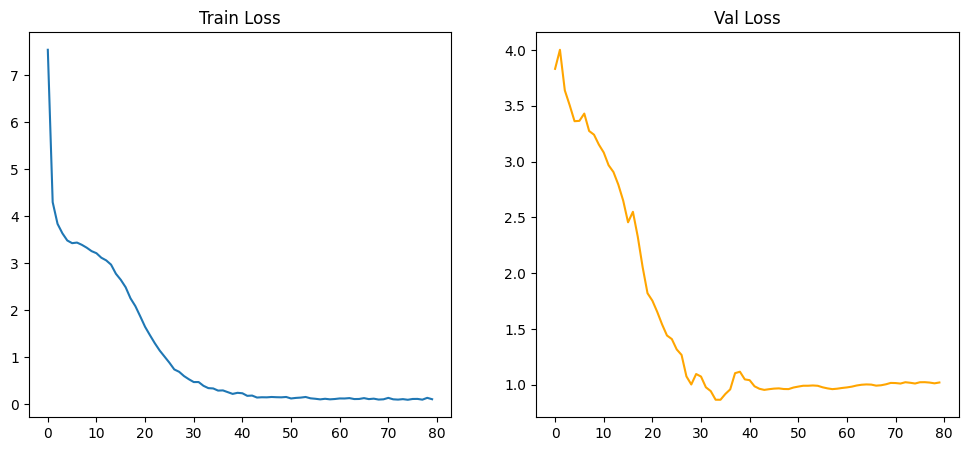

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Train Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
plt.show()

#10. Visualize Predictions

In [14]:
samples = []

for _ in range(20):
    idx = np.random.randint(len(test_dataset))
    img, label, _ = test_dataset[idx]
    img = img.to(DEVICE)

    logits = crnn_model(img.unsqueeze(0))
    pred = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]
    gt = decode_label([label], idx_to_char)[0]

    samples.append((img.cpu(), gt, pred))


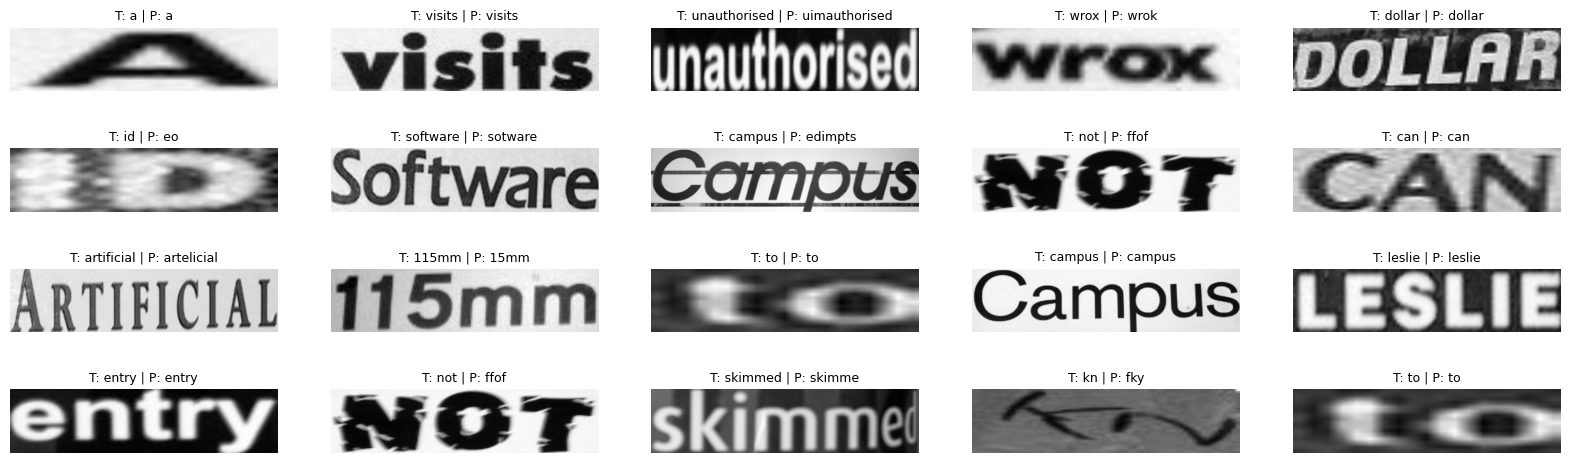

In [15]:
fig = plt.figure(figsize=(20, 6))

for i, (img, gt, pred) in enumerate(samples):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(f"T: {gt} | P: {pred}", fontsize=9)
    ax.axis("off")

plt.show()


In [16]:
crnn_path = os.path.join(PROJECT_ROOT, "model/cnn/ocr_crnn.pt")
os.makedirs(os.path.dirname(crnn_path), exist_ok=True)

torch.save(crnn_model.state_dict(), crnn_path)
print(f"CRNN saved to: {crnn_path}")

print(f"YOLO model saved to: {PROJECT_ROOT}/model/yolo/best.pt")

CRNN saved to: /content/drive/MyDrive/Information-Extraction-from-Image/model/cnn/ocr_crnn.pt
YOLO model saved to: /content/drive/MyDrive/Information-Extraction-from-Image/model/yolo/best.pt
